# Methanol and Pig Iron Production System

This notebook demonstrates `optimex` on a realistic case study using **ecoinvent** and **premise** (REMIND-EU SSP2-NDC scenario) databases. It optimizes the transition pathway for two coupled product systems:

- **Methanol**: via CO2 hydrogenation (green route) or natural gas reforming (conventional)
- **Pig iron**: via H2-based direct reduction, blast furnace with carbon capture, or conventional blast furnace

Intermediate products (hydrogen, captured CO2) create cross-linkages between the systems.

**Prerequisites**: ecoinvent 3.12 + premise databases must be set up (see `premise_database_setup.ipynb`).


<!-- <div style="display: flex; background-color: white; border-radius: 15px; padding: 10px; width: 800px;">
  <img src="data/product_system.svg" style="border-radius: 15px; width: 100%;">
</div> -->
<!-- For Docs: -->
<div style="display: flex; background-color: white; border-radius: 15px; padding: 10px; width: calc(100% - 20px); margin: 0 auto;">
  <img src="../data/product_system.svg" style="border-radius: 15px; width: 100%;">
</div>

In [ ]:
import bw2data as bd

bd.projects.set_current("optimex_remind")

## Background Inputs from ecoinvent/premise

Retrieve background processes (electricity, heat, water, infrastructure, raw materials) and biosphere flows from the premise-modified ecoinvent databases.


In [2]:
electricity_mv = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market group for electricity, medium voltage",
    location="RER",
)
electricity_lv = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market group for electricity, low voltage",
    location="RER",
)
heat = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for heat, district or industrial",
    location="DEU",
)  # Process not available for RER
water_tap = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for tap water",
    location="Europe without Switzerland",
)
water_deionized = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="deionized water production, via reverse osmosis, from brackish water",
    location="RER",
)

dac_system = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="direct air capture system, solvent-based, 1MtCO2",
    location="RER",
)
dac_system_eol = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="treatment of direct air capture system, solvent-based, 1MtCO2",
    location="RER",
)

pem_stack = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="electrolyzer production, 1MWe, PEM, Stack",
    location="RER",
)
pem_stack_eol = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="treatment of electrolyzer stack, 1MWe, PEM",
    location="RER",
)
pem_bop = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="electrolyzer production, 1MWe, PEM, Balance of Plant",
    location="RER",
)
pem_bop_eol = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="treatment of electrolyzer balance of plant, 1MWe, PEM",
    location="RER",
)

methanol_production_facility = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="methanol production facility, construction",
    location="RER",
)

blast_furnace_production = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for blast furnace",
    location="GLO",
)
coke = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020", name="market for coke", location="RoW"
)
hard_coal = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market group for hard coal",
    location="RER",
)
iron_ore_concentrate = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for iron ore concentrate",
    location="World",
)
iron_sinter = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="iron sinter production",
    location="RER",
)
iron_pellet = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for iron pellet",
    location="GLO",
)
natural_gas = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="petroleum and gas production, offshore",
    product="natural gas, high pressure",
    location="DE",
)

methanol_factory_ng = bd.get_node(
    database="ei312_REMIND-EU_SSP2_NDC_2020",
    name="market for methanol factory",
    location="GLO",
)

In [3]:
co2 = bd.get_node(
    database="ecoinvent-3.12-biosphere",
    name="Carbon dioxide, fossil",
    categories=("air",),
)

particulate_matter_sm = bd.get_node(
    database="ecoinvent-3.12-biosphere",
    name="Particulate Matter, < 2.5 um",
    categories=("air",),
)
particulate_matter_md = bd.get_node(
    database="ecoinvent-3.12-biosphere",
    name="Particulate Matter, > 2.5 um and < 10um",
    categories=("air",),
)
particulate_matter_lg = bd.get_node(
    database="ecoinvent-3.12-biosphere",
    name="Particulate Matter, > 10 um",
    categories=("air",),
)

## Foreground Setup

Define the decision-relevant foreground system. Each process has:

- **`operation_time_limits`**: when the operation phase occurs within the process lifetime
- **`operation=True`** on exchanges that scale with operational level
- **`vintage_improvements`**: efficiency gains for processes installed in later years
- Construction and end-of-life exchanges with appropriate temporal distributions

Helper functions (`infer_operation_td_from_limits`, etc.) automatically generate temporal distributions from the operation time limits.


In [ ]:
if "foreground" in bd.databases:
    del bd.databases["foreground"]  # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

### Products

Four products in the system: methanol and pig iron (final demand), hydrogen and captured CO2 (intermediates).


In [5]:
methanol = foreground.new_node(
    name="methanol",
    code="methanol",
    unit="kg",
    type=bd.labels.product_node_default,
)
methanol.save()

iron = foreground.new_node(
    name="pig iron",
    code="pig iron",
    unit="kg",
    type=bd.labels.product_node_default,
)
iron.save()

hydrogen = foreground.new_node(
    name="hydrogen",
    code="hydrogen",
    unit="kg",
    type=bd.labels.product_node_default,
)
hydrogen.save()

captured_co2 = foreground.new_node(
    name="captured CO2",
    code="captured CO2",
    unit="kg",
    type=bd.labels.product_node_default,
)
captured_co2.save()

### Processes


In [ ]:
from optimex.utils import (
    infer_operation_td_from_limits,
    infer_construction_td_from_limits,
    infer_eol_td_from_limits,
)

#### Direct Air Capture (DAC)

Solvent-based DAC producing captured CO2. 15-year operation lifetime. Electricity and heat consumption improve with vintage year.


In [ ]:
dac = foreground.new_node(
    name="direct air carbon capture",
    code="direct air carbon capture",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 15),
)
dac.save()

In [ ]:
# operation
dac.new_edge(
    input=captured_co2,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(dac),
).save()

dac.new_edge(
    input=electricity_mv,
    amount=0.345,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(dac),
).save()

dac.new_edge(
    input=heat,
    amount=6.28,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(dac),
).save()

dac.new_edge(
    input=water_tap,
    amount=3.437,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(dac),
).save()

dac.new_edge(
    input=co2,
    amount=-1.0,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(dac),
).save()

# construction
dac.new_edge(
    input=dac_system,
    amount=5e-11,  # 5e-11
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(dac),
).save()

# end-of-life
dac.new_edge(
    input=dac_system_eol,
    amount=-5e-11,  # 5e-11
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_eol_td_from_limits(dac),
).save()

#### PEM Electrolysis

Produces hydrogen from electricity and water. 8-year stack lifetime. Electricity consumption improves with vintage.


In [ ]:
pem = foreground.new_node(
    name="PEM Electrolysis",
    code="PEM Electrolysis",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 8),
)
pem.save()

In [10]:
# operation
pem.new_edge(
    input=hydrogen,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(pem),
).save()

pem.new_edge(
    input=electricity_lv,
    amount=54,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(pem),
).save()

pem.new_edge(
    input=water_deionized,
    amount=14,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(pem),
).save()

# construction
pem.new_edge(
    input=pem_stack,
    amount=1.34989e-6,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(pem),
).save()

pem.new_edge(
    input=pem_bop,
    amount=3.37373e-7,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(pem),
).save()

# end-of-life
pem.new_edge(
    input=pem_stack_eol,
    amount=-1.34989e-6,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_eol_td_from_limits(pem),
).save()

pem.new_edge(
    input=pem_bop_eol,
    amount=-3.37373e-7,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_eol_td_from_limits(pem),
).save()

#### CO2 Hydrogenation to Methanol

Green methanol route: combines hydrogen and captured CO2. 15-year lifetime. Electricity consumption and CO2 emissions improve with vintage.


In [ ]:
co2_hydrogenation = foreground.new_node(
    name="Carbon dioxide hydrogenation to methanol",
    code="Carbon dioxide hydrogenation to methanol",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 15),
)
co2_hydrogenation.save()

In [12]:
# operation
co2_hydrogenation.new_edge(
    input=methanol,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

co2_hydrogenation.new_edge(
    input=hydrogen,
    amount=0.138975,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

co2_hydrogenation.new_edge(
    input=captured_co2,
    amount=1.690523,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

co2_hydrogenation.new_edge(
    input=electricity_lv,
    amount=0.302895,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

co2_hydrogenation.new_edge(
    input=water_tap,
    amount=0.81959,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

co2_hydrogenation.new_edge(
    input=co2,
    amount=0.32,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(co2_hydrogenation),
).save()

# construction
co2_hydrogenation.new_edge(
    input=methanol_production_facility,
    amount=12.89,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(co2_hydrogenation),
).save()

#### Blast Furnace with Carbon Capture

Conventional iron production with post-combustion CO2 capture. Co-produces pig iron and captured CO2. 25-year lifetime. PM emissions reduced by 50% through co-capture.


In [ ]:
blast_furnace_cc = foreground.new_node(
    name="Blast furnace with carbon capture",
    code="Blast furnace with carbon capture",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 25),
)
blast_furnace_cc.save()

In [ ]:
total_co2_emission_per_kg_iron = 0.849
captured_co2_per_kg_iron = 0.7054  # Happrecht et al., 2025, SI Section 1.3.2
total_pm_sm_emission_per_kg_iron = 2.8723e-5
total_pm_md_emission_per_kg_iron = 1.5957e-6
total_pm_lg_emission_per_kg_iron = 1.5957e-6
pm_emission_reduction = (
    0.5  # PM reduction through co-capture, Choi, 2013; Singh et al., 2011
)

# operation
blast_furnace_cc.new_edge(
    input=iron,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=captured_co2,
    amount=captured_co2_per_kg_iron,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=co2,
    amount=total_co2_emission_per_kg_iron - captured_co2_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=natural_gas,
    amount=2.71 / 36,  # Happrecht et al., 2025, SI Section 1.3.2 w/ 36 MJ/m3
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=coke,
    amount=9.724,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=hard_coal,
    amount=0.15,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=iron_ore_concentrate,
    amount=0.15,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=iron_pellet,
    amount=0.4,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=iron_sinter,
    amount=1.05,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=particulate_matter_sm,
    amount=(1 - pm_emission_reduction) * total_pm_sm_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=particulate_matter_md,
    amount=(1 - pm_emission_reduction) * total_pm_md_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

blast_furnace_cc.new_edge(
    input=particulate_matter_lg,
    amount=(1 - pm_emission_reduction) * total_pm_lg_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace_cc),
).save()

# construction
blast_furnace_cc.new_edge(
    input=blast_furnace_production,
    amount=1.333e-11,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(blast_furnace_cc),
).save()

#### Blast Furnace (conventional)

Standard blast furnace without carbon capture. Same inputs as above but full CO2 and PM emissions. 25-year lifetime.


In [ ]:
blast_furnace = foreground.new_node(
    name="Blast furnace",
    code="Blast furnace",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 25),
)
blast_furnace.save()

In [ ]:
# operation
blast_furnace.new_edge(
    input=iron,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=co2,
    amount=total_co2_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=natural_gas,
    amount=2.71 / 36,  # Happrecht et al., 2025, SI Section 1.3.2 w/ 36 MJ/m3
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=coke,
    amount=9.724,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=hard_coal,
    amount=0.15,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=iron_ore_concentrate,
    amount=0.15,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=iron_pellet,
    amount=0.4,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=iron_sinter,
    amount=1.05,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=particulate_matter_sm,
    amount=total_pm_sm_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=particulate_matter_md,
    amount=total_pm_md_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

blast_furnace.new_edge(
    input=particulate_matter_lg,
    amount=total_pm_lg_emission_per_kg_iron,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(blast_furnace),
).save()

# construction
blast_furnace.new_edge(
    input=blast_furnace_production,
    amount=1.333e-11,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(blast_furnace),
).save()

#### Direct Reduction of Iron (H2-DRI)

Hydrogen-based iron reduction with much lower direct CO2 emissions. Consumes hydrogen, iron pellets, natural gas, and electricity. 25-year lifetime.


In [ ]:
direct_reduction = foreground.new_node(
    name="Direct reduction of iron",
    code="Direct reduction of iron",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 25),
)
direct_reduction.save()

In [ ]:
dri_h2_consumption = 0.06264
dri_iron_pellet_consumption = 1.359733

# operation
direct_reduction.new_edge(
    input=iron,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

direct_reduction.new_edge(
    input=co2,
    amount=0.03271,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

direct_reduction.new_edge(
    input=hydrogen,
    amount=dri_h2_consumption,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

direct_reduction.new_edge(
    input=natural_gas,
    amount=0.0358938,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

direct_reduction.new_edge(
    input=iron_pellet,
    amount=dri_iron_pellet_consumption,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

direct_reduction.new_edge(
    input=electricity_mv,
    amount=0.0192446
    + dri_h2_consumption * 4.024497
    + dri_iron_pellet_consumption * 0.27267,  # incl. h2 and iron pellet preheating
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(direct_reduction),
).save()

# construction
direct_reduction.new_edge(
    input=blast_furnace_production,
    amount=1.333e-11,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(direct_reduction),
).save()

#### Natural Gas Reforming to Methanol

Conventional methanol production from natural gas. 25-year lifetime. No vintage improvements.


In [ ]:
ng_reforming = foreground.new_node(
    name="Natural gas reforming",
    code="Natural gas reforming",
    location="RER",
    type=bd.labels.process_node_default,
    operation_time_limits=(0, 25),
)
ng_reforming.save()

In [20]:
# operation
ng_reforming.new_edge(
    input=methanol,
    amount=1.0,
    type=bd.labels.production_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(ng_reforming),
).save()

ng_reforming.new_edge(
    input=co2,
    amount=0.33424,
    type=bd.labels.biosphere_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(ng_reforming),
).save()


ng_reforming.new_edge(
    input=natural_gas,
    amount=0.8895,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(ng_reforming),
).save()

ng_reforming.new_edge(
    input=water_deionized,
    amount=0.355,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(ng_reforming),
).save()

ng_reforming.new_edge(
    input=electricity_mv,
    amount=0.0886,
    type=bd.labels.consumption_edge_default,
    operation=True,
    temporal_distribution=infer_operation_td_from_limits(ng_reforming),
).save()

# construction
ng_reforming.new_edge(
    input=methanol_factory_ng,
    amount=3.716e-11,
    type=bd.labels.consumption_edge_default,
    temporal_distribution=infer_construction_td_from_limits(ng_reforming),
).save()

## Optimex Setup

Configure the LCA processing and prepare optimization inputs. This involves:

1. Registering premise background databases with their representative years
2. Defining time-varying demand for methanol and pig iron
3. Selecting impact categories (climate change with CRF, particulate matter, land use, water use)
4. Running the LCA data processor to extract all tensors


### Background Databases and Demand

Register premise databases (2020-2100) with their representative times, then define constant demand of 1 Mt/year for both methanol and pig iron from 2025 to 2050.


In [21]:
from datetime import datetime

dbs = {
    2020: bd.Database("ei312_REMIND-EU_SSP2_NDC_2020"),
    2030: bd.Database("ei312_REMIND-EU_SSP2_NDC_2030"),
    2040: bd.Database("ei312_REMIND-EU_SSP2_NDC_2040"),
    2050: bd.Database("ei312_REMIND-EU_SSP2_NDC_2050"),
    2075: bd.Database("ei312_REMIND-EU_SSP2_NDC_2075"),
    2100: bd.Database("ei312_REMIND-EU_SSP2_NDC_2100"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

In [ ]:
from bw_temporalis import TemporalDistribution
import numpy as np

years = range(2025, 2051)
rng = np.random.default_rng(25)

# methanol demand
trend_meoh = np.linspace(1, 1, len(years))
# noise_meoh = rng.normal(0, 4.0, len(years))
noise_meoh = rng.normal(0, 0, len(years))
amount_meoh = trend_meoh + noise_meoh

td_methanol = TemporalDistribution(
    date=np.array(
        [datetime(year, 1, 1).isoformat() for year in years],
        dtype="datetime64[s]",
    ),
    amount=amount_meoh * 1e6,  # Mt scale
)

# iron demand
trend_iron = np.linspace(1, 1, len(years))
# noise_iron = rng.normal(0, 8.0, len(years))
noise_iron = rng.normal(0, 0, len(years))
amount_iron = trend_iron + noise_iron

td_iron = TemporalDistribution(
    date=np.array(
        [datetime(year, 1, 1).isoformat() for year in years],
        dtype="datetime64[s]",
    ),
    amount=amount_iron * 1e6,  # Mt scale
)

functional_demand = {methanol: td_methanol, iron: td_iron}

In [ ]:
method_climate_change = ("IPCC 2021", "climate change", "GWP 100a, incl. H and bio CO2")

method_land_use = (
    "ecoinvent-3.12",
    "EF v3.1 no LT",
    "land use no LT",
    "soil quality index no LT",
)

method_particulate_matter = (
    "ecoinvent-3.12",
    "EF v3.1 no LT",
    "particulate matter formation no LT",
    "impact on human health no LT",
)

method_water_use = (
    "ecoinvent-3.12",
    "EF v3.1 no LT",
    "water use no LT",
    "user deprivation potential (deprivation-weighted water consumption) no LT",
)

In [ ]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand=functional_demand,
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method_climate_change,
            "metric": "CRF",  # CRF
        },
        {
            "category_name": "particulate_matter",
            "brightway_method": method_particulate_matter,
        },
        {
            "category_name": "land_use",
            "brightway_method": method_land_use,
        },
        {
            "category_name": "water_use",
            "brightway_method": method_water_use,
        },
    ],
)

In [ ]:
from optimex import converter

lca_data_processor = lca_processor.LCADataProcessor(lca_config)
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor)

In [ ]:
manager.save(
    "data/model_inputs_2050.json"
)  # if you want to save the model inputs to a file

## Optimization Scenarios

We run multiple scenarios to demonstrate different `optimex` features. All scenarios assume existing blast furnace and NG reforming capacity installed in 2005 and 2015.

The model inputs can be saved and reloaded to avoid re-running the LCA processing step.


In [4]:
from optimex import converter

manager = converter.ModelInputManager()

_ = manager.load_inputs(
    "data/paper/model_inputs_2050_paper.json"
)  # if you want to load the model inputs from a file

### Scenario 1: Baseline

Baseline scenario: background databases are frozen at 2020 (no technological progress in the background system). This isolates the effect of foreground process choices.


In [9]:
existing_capacities = {
    ("Blast furnace", 2005): 0.5e6,
    ("Blast furnace", 2015): 0.5e6,
    ("Natural gas reforming", 2005): 0.5e6,
    ("Natural gas reforming", 2015): 0.5e6,
}

no_background_evolution_mapping = {
    ("ei312_REMIND-EU_SSP2_NDC_2020", year): 1.0 for year in range(2020, 2051)
}

optimization_model_inputs_baseline = manager.override(
    existing_capacity=existing_capacities,
    mapping=no_background_evolution_mapping,
    vintage_improvements=None,
)

In [10]:
from optimex import optimizer

model_baseline = optimizer.create_model(
    optimization_model_inputs_baseline,
    name="no_evolution",
    objective_category="climate_change",
)

2026-02-11 11:19:16.373 | INFO     | optimex.optimizer:create_model:116 - Creating sets
2026-02-11 11:19:16.374 | INFO     | optimex.optimizer:create_model:158 - Creating parameters
2026-02-11 11:19:16.519 | INFO     | optimex.optimizer:create_model:448 - Creating variables


In [11]:
m_baseline, obj_baseline, results_baseline = optimizer.solve_model(
    model_baseline, solver_name="gurobi", tee=False
)

2026-02-11 11:21:21.815 | INFO     | optimex.optimizer:solve_model:1113 - Solver [gurobi] termination: optimal
2026-02-11 11:22:08.049 | INFO     | optimex.optimizer:solve_model:1127 - Objective (scaled): 2778
2026-02-11 11:22:08.052 | INFO     | optimex.optimizer:solve_model:1128 - Objective (real):   4.62873e-06


In [12]:
from optimex import postprocessing

pp_baseline = postprocessing.PostProcessor(m_baseline, plot_config={"figsize": (8, 4)})

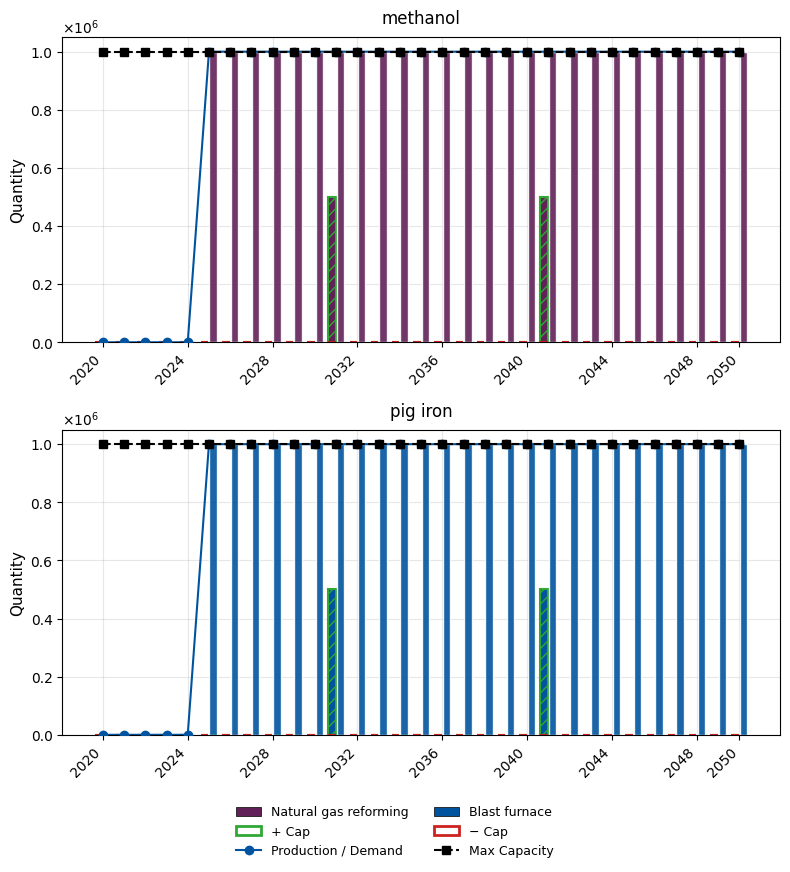

In [13]:
pp_baseline.plot_capacity_balance(detailed=True)

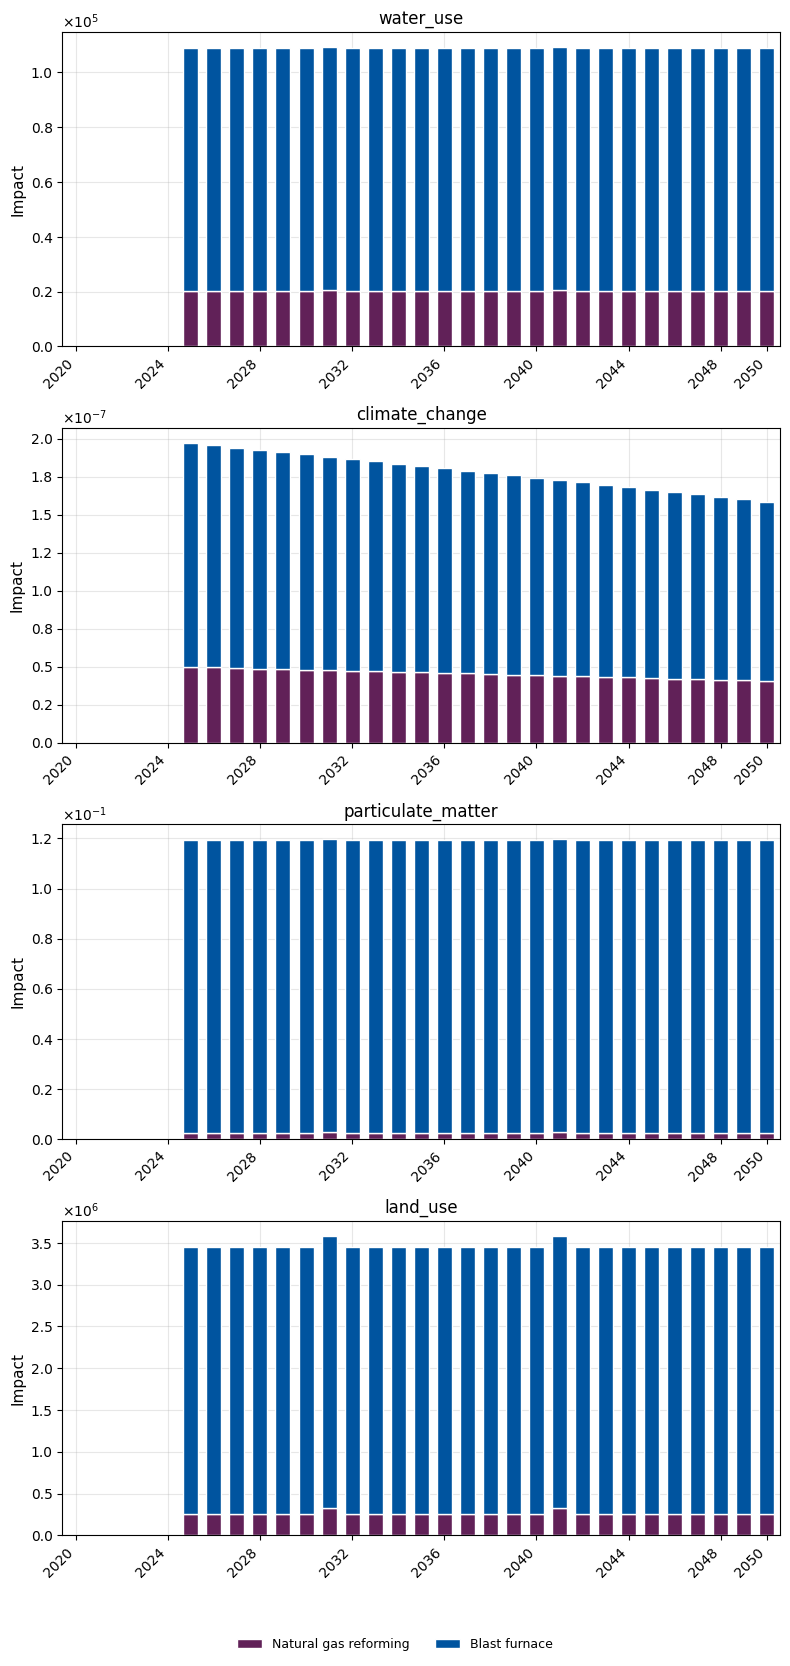

In [14]:
pp_baseline.plot_impacts()

In [ ]:
pp_baseline.get_characterized_dynamic_inventory(
    base_lcia_method=method_climate_change
)

pp_baseline.df_dynamic_inventory.to_excel(
    "data/paper/dynamic_inventory_no_evolution.xlsx"
)
pp_baseline.df_characterized_inventory.to_excel(
    "data/paper/characterized_inventory_no_evolution.xlsx"
)
pp_baseline.df_production.to_excel("data/paper/production_no_evolution.xlsx")
pp_baseline.df_demand.to_excel("data/paper/demand_no_evolution.xlsx")
pp_baseline.get_production_capacity().to_excel(
    "data/paper/capacity_no_evolution.xlsx"
)
pp_baseline.df_impacts.to_excel("data/paper/impacts_no_evolution.xlsx")

### Scenario 2: Evolution

Background databases evolve according to the REMIND-EU SSP2-NDC scenario (interpolated between 2020-2100). This reflects decarbonization of electricity grids, material supply chains, etc.


In [16]:
manager.load_inputs("data/paper/model_inputs_2050_paper.json")

vintage_improvements = {
    ("PEM Electrolysis", electricity_lv["code"], 2020): 1,
    ("PEM Electrolysis", electricity_lv["code"], 2030): 0.97,
    ("PEM Electrolysis", electricity_lv["code"], 2040): 0.95,
    ("PEM Electrolysis", electricity_lv["code"], 2050): 0.94,
    ("direct air carbon capture", electricity_mv["code"], 2020): 1,
    ("direct air carbon capture", electricity_mv["code"], 2030): 0.96,
    ("direct air carbon capture", electricity_mv["code"], 2040): 0.94,
    ("direct air carbon capture", electricity_mv["code"], 2050): 0.93,
    ("direct air carbon capture", heat["code"], 2020): 1,
    ("direct air carbon capture", heat["code"], 2030): 0.95,
    ("direct air carbon capture", heat["code"], 2040): 0.92,
    ("direct air carbon capture", heat["code"], 2050): 0.90,
    ("Carbon dioxide hydrogenation to methanol", co2["code"], 2020): 1,
    ("Carbon dioxide hydrogenation to methanol", co2["code"], 2030): 0.98,
    ("Carbon dioxide hydrogenation to methanol", co2["code"], 2040): 0.97,
    ("Carbon dioxide hydrogenation to methanol", co2["code"], 2050): 0.96,
    ("Carbon dioxide hydrogenation to methanol", electricity_lv["code"], 2020): 1,
    ("Carbon dioxide hydrogenation to methanol", electricity_lv["code"], 2030): 0.98,
    ("Carbon dioxide hydrogenation to methanol", electricity_lv["code"], 2040): 0.97,
    ("Carbon dioxide hydrogenation to methanol", electricity_lv["code"], 2050): 0.96,
}

optimization_model_inputs_evolution = manager.override(
    existing_capacity=existing_capacities,
    vintage_improvements=vintage_improvements,
)

In [17]:
from optimex import optimizer

model_evolution = optimizer.create_model(
    optimization_model_inputs_evolution,
    name="evolution",
    objective_category="climate_change",
)

2026-02-11 11:25:24.863 | INFO     | optimex.optimizer:create_model:116 - Creating sets
2026-02-11 11:25:24.865 | INFO     | optimex.optimizer:create_model:158 - Creating parameters
2026-02-11 11:25:25.014 | INFO     | optimex.optimizer:create_model:448 - Creating variables


In [18]:
m_evolution, obj_evolution, results_evolution = optimizer.solve_model(
    model_evolution, solver_name="gurobi", tee=False
)

2026-02-11 11:27:35.494 | INFO     | optimex.optimizer:solve_model:1113 - Solver [gurobi] termination: optimal
2026-02-11 11:28:20.604 | INFO     | optimex.optimizer:solve_model:1127 - Objective (scaled): 1090.77
2026-02-11 11:28:20.607 | INFO     | optimex.optimizer:solve_model:1128 - Objective (real):   1.81746e-06


In [19]:
from optimex import postprocessing

pp_evolution = postprocessing.PostProcessor(m_evolution, plot_config={"figsize": (8, 4)})

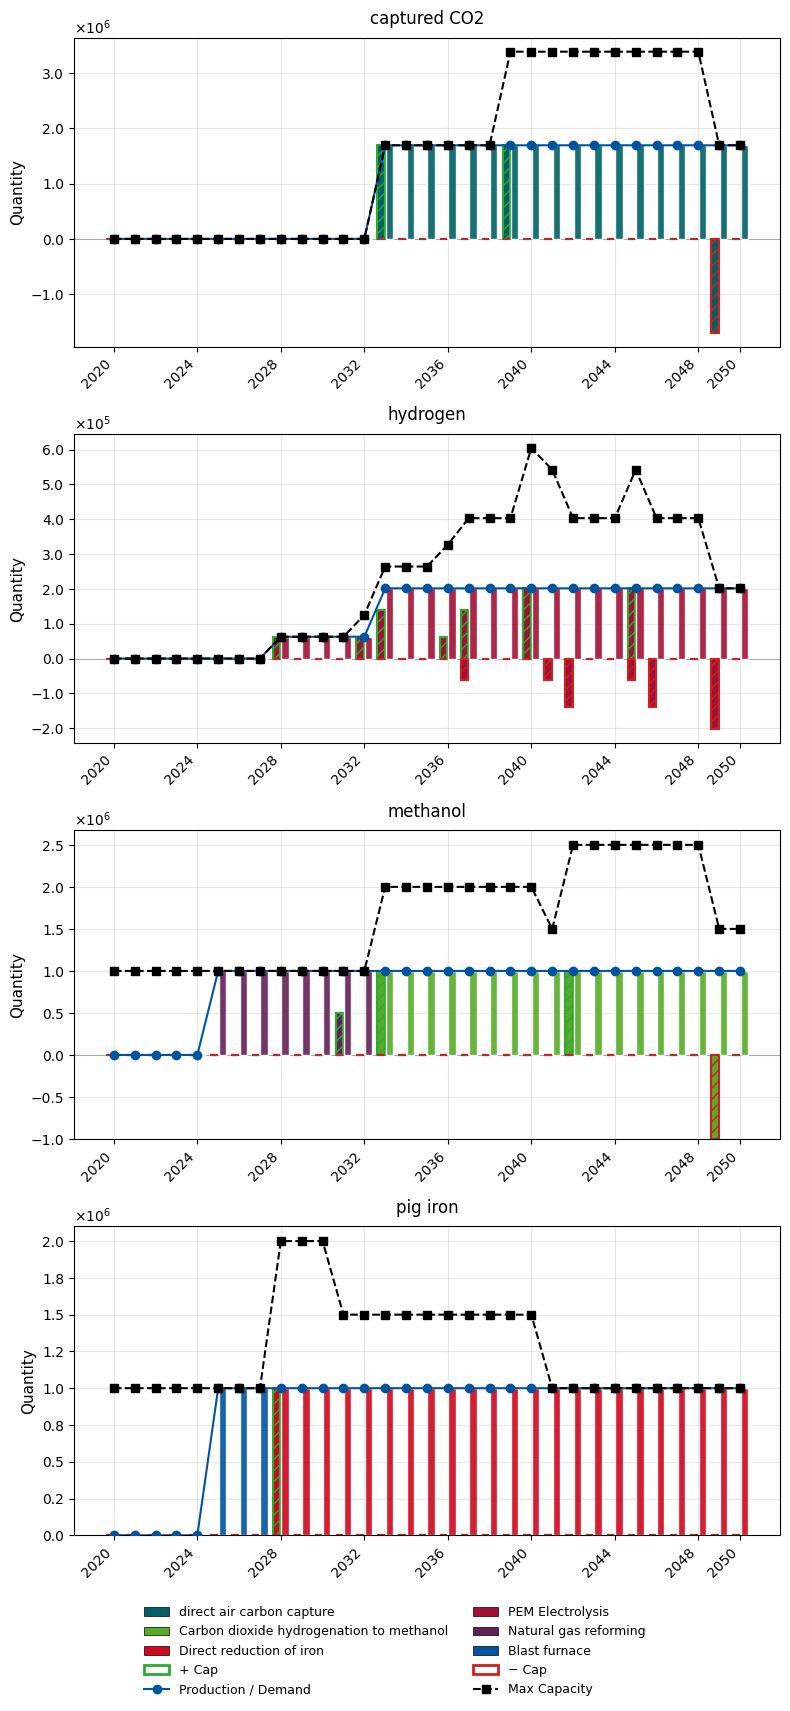

In [20]:
pp_evolution.plot_capacity_balance(detailed=True)

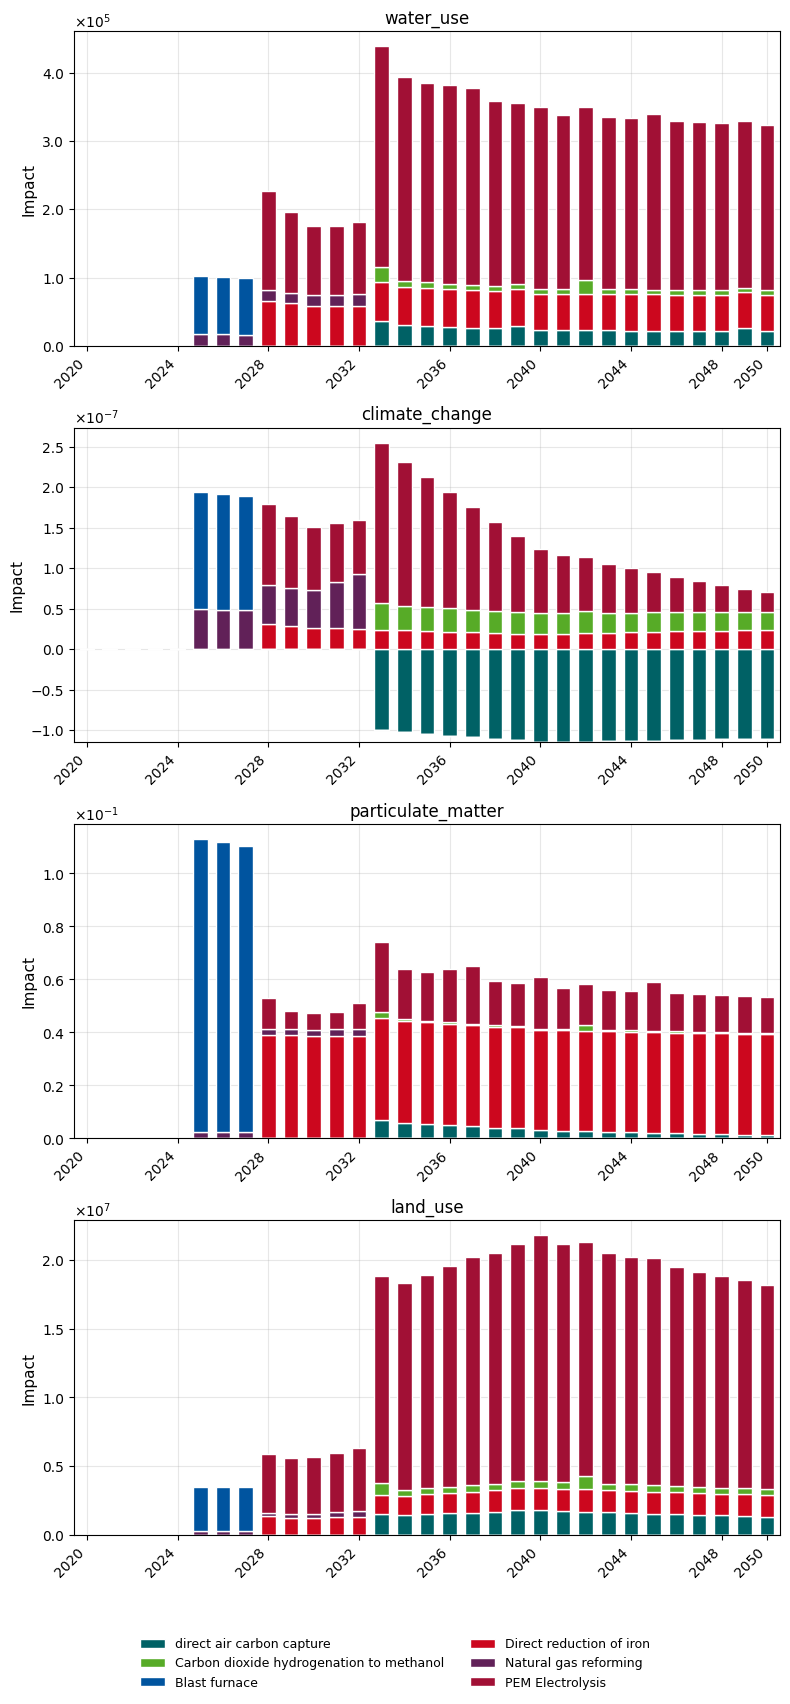

In [21]:
pp_evolution.plot_impacts()

In [61]:
pp_evolution.get_characterized_dynamic_inventory(base_lcia_method=method_climate_change)

pp_evolution.df_dynamic_inventory.to_excel(
    "data/paper/dynamic_inventory_evolution.xlsx"
)
pp_evolution.df_characterized_inventory.to_excel(
    "data/paper/characterized_inventory_evolution.xlsx"
)
pp_evolution.df_production.to_excel("data/paper/production_evolution.xlsx")
pp_evolution.df_demand.to_excel("data/paper/demand_evolution.xlsx")
pp_evolution.get_production_capacity().to_excel("data/paper/capacity_evolution.xlsx")
pp_evolution.df_impacts.to_excel("data/paper/impacts_evolution.xlsx")

2026-02-10 15:44:25.663 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


### Scenario 3: Water Use and Iridium Resource constraint

Adds a maximum annual water use impact limit (300,000 units/year) and a cumulative iridium resource limit (0.125 kg) constrained on top of the climate change objective. This demonstrates how constraints affect deployment decisions.


In [22]:
iridium = bd.get_node(database="ecoinvent-3.12-biosphere", name="Iridium")

In [23]:
manager.load_inputs("data/paper/model_inputs_2050_paper.json")

start_year = 2025
end_year = 2051  # range is exclusive, so this covers up to 2060
reduction_rate = 0

base_water_limit = 300_000

optimization_model_inputs_constrained = manager.override(
    existing_capacity=existing_capacities,
    vintage_improvements=vintage_improvements,
    category_impact_limits={
        ("water_use", year): base_water_limit
        * ((1 - reduction_rate) ** (year - start_year))
        for year in range(start_year, end_year)
    },
    cumulative_flow_limits_max={
        iridium["code"]: 0.125,
    },
)

In [24]:
from optimex import optimizer

model_constrained = optimizer.create_model(
    optimization_model_inputs_constrained,
    name="constrained",
    objective_category="climate_change",
)

2026-02-11 11:31:25.100 | INFO     | optimex.optimizer:create_model:116 - Creating sets
2026-02-11 11:31:25.102 | INFO     | optimex.optimizer:create_model:158 - Creating parameters
2026-02-11 11:31:25.250 | INFO     | optimex.optimizer:create_model:448 - Creating variables


In [25]:
m_constrained, obj_constrained, results_constrained = optimizer.solve_model(
    model_constrained, solver_name="gurobi", tee=False
)  # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2026-02-11 11:33:24.088 | INFO     | optimex.optimizer:solve_model:1113 - Solver [gurobi] termination: optimal
2026-02-11 11:34:08.907 | INFO     | optimex.optimizer:solve_model:1127 - Objective (scaled): 1765.32
2026-02-11 11:34:08.908 | INFO     | optimex.optimizer:solve_model:1128 - Objective (real):   2.9414e-06


In [26]:
from optimex import postprocessing

pp_constrained = postprocessing.PostProcessor(m_constrained, plot_config={"figsize": (8, 4)})

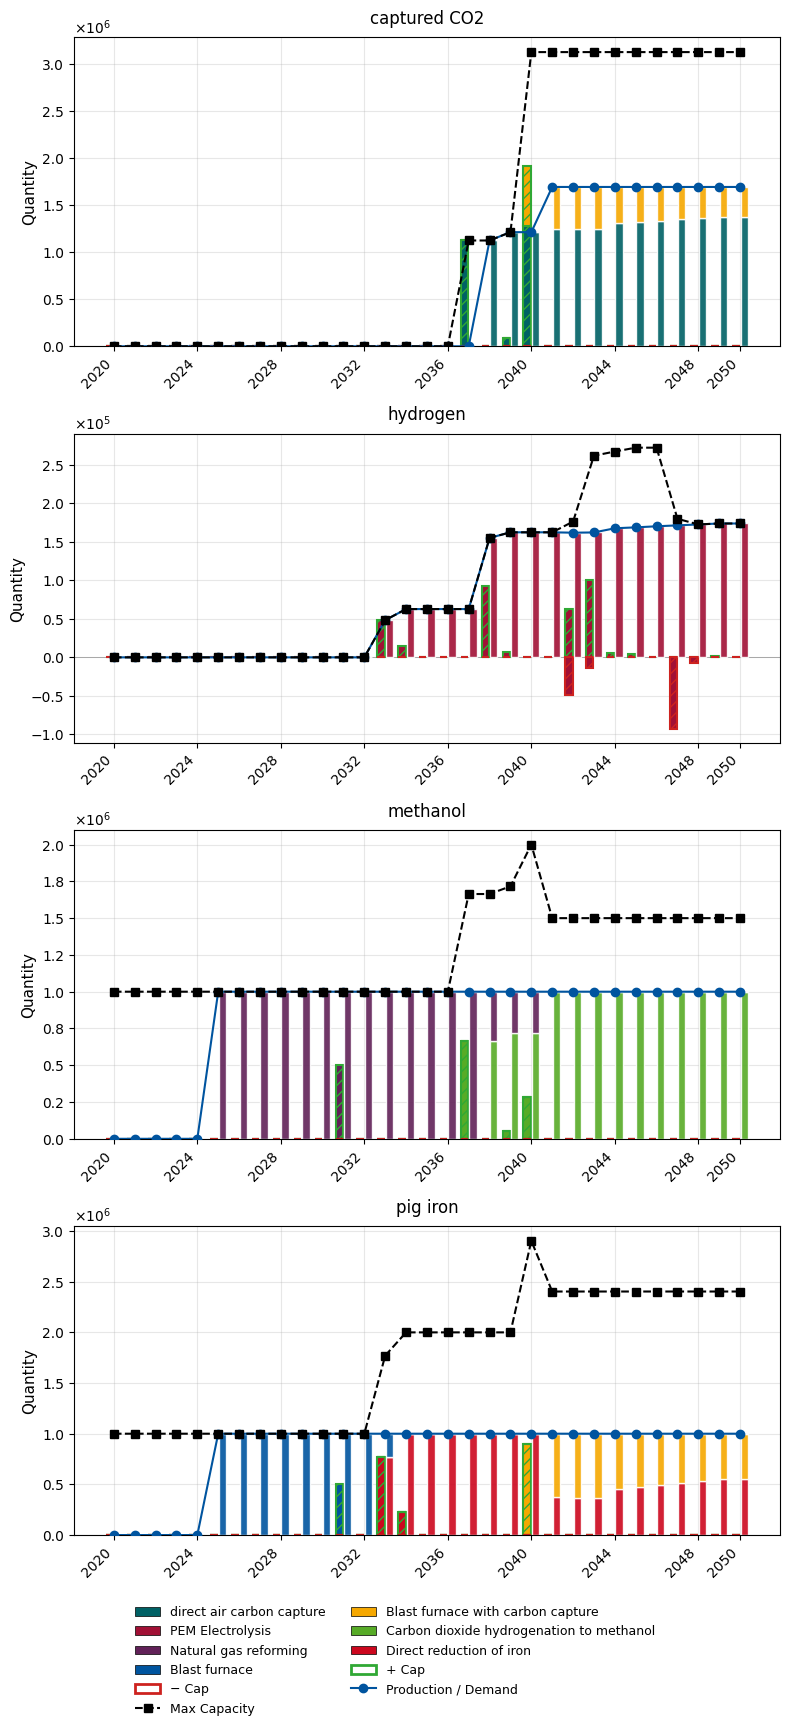

In [27]:
pp_constrained.plot_capacity_balance(detailed=True)

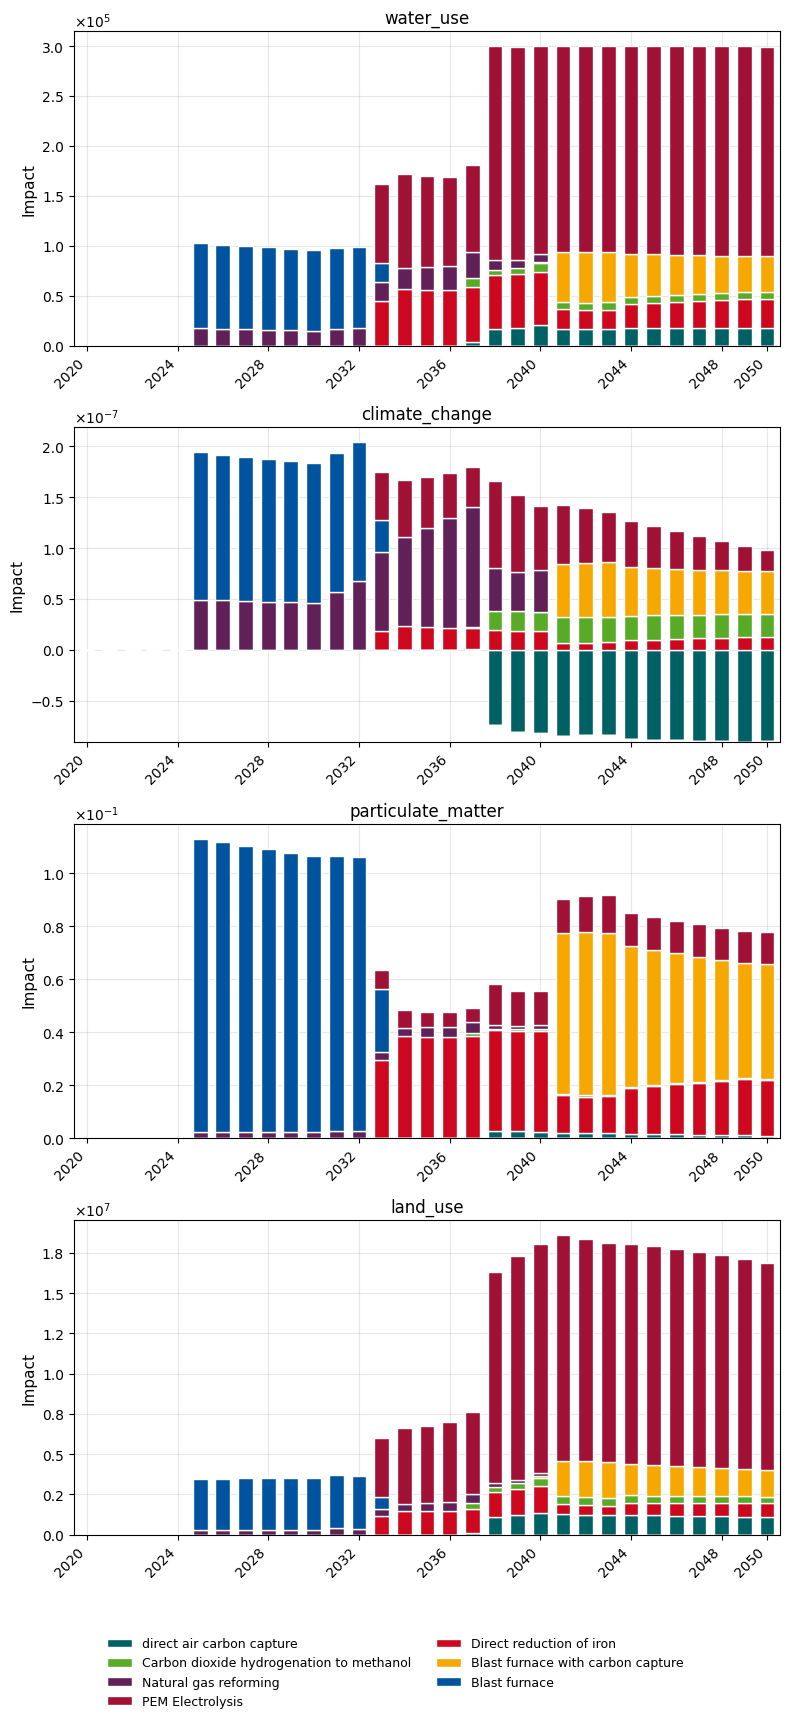

In [28]:
pp_constrained.plot_impacts()

In [70]:
pp_constrained.get_characterized_dynamic_inventory(
    base_lcia_method=method_climate_change
)

pp_constrained.df_dynamic_inventory.to_excel(
    "data/paper/dynamic_inventory_constrained.xlsx"
)
pp_constrained.df_characterized_inventory.to_excel(
    "data/paper/characterized_inventory_constrained.xlsx"
)
pp_constrained.df_production.to_excel("data/paper/production_constrained.xlsx")
pp_constrained.df_demand.to_excel("data/paper/demand_constrained.xlsx")
pp_constrained.get_production_capacity().to_excel(
    "data/paper/capacity_constrained.xlsx"
)
pp_constrained.df_impacts.to_excel("data/paper/impacts_constrained.xlsx")

2026-02-10 15:58:56.630 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
